In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/MiCM2021-PKD/beta/
my_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/'

/content/drive/MyDrive/MiCM2021-PKD/beta


In [3]:
!pip install pydicom

In [4]:
!pip install tqdm

In [5]:
!pip install utils

In [4]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import torch.optim as optim
import os
from UNET import UNET
from dataset import SliceDataset
import torch
import math
from DiceLoss import myDiceLoss
from transform import transforms
from utils import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
    load_seg,
    remove_bg_only_test,
    clean_test_ds
)
import time
import numpy as np


In [5]:
def train_fn(train_dataloader, model, optimizer, loss_fn, scaler):
    loop = tqdm(train_dataloader, position=0, leave=True)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.unsqueeze(1).to(device=DEVICE)

        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            # print("pred: ", predictions.shape)
            loss = loss_fn.forward(predictions, targets)
            # loss = loss_fn(predictions, targets)
            # print("loss: ", loss.shape)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOAD_MODEL = False
ORGAN = 'lv'

In [7]:

my_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/MR2D/Train'
img_paths = []
for dcm in os.listdir(my_dir + '/X'):
    if dcm != ".DS_Store":
        img_paths.append(my_dir + '/X/' + dcm)
img_paths.sort()

seg_paths = []
for seg in os.listdir(my_dir + '/Y'):
    if seg != ".DS_Store":
        seg_paths.append(my_dir + '/Y/' + seg)
seg_paths.sort()

    # Train = ds.SliceDataset(img_paths, seg_paths)
train_idx = random.sample(range(0, len(img_paths)), math.ceil(0.75*len(img_paths)))
train_img_paths = []
train_seg_paths = []
val_img_paths = []
val_seg_paths = []
for idx in range(len(img_paths)):
    if idx in train_idx:
        train_img_paths.append(img_paths[idx])
        train_seg_paths.append(seg_paths[idx])
    else:
        val_img_paths.append(img_paths[idx])
        val_seg_paths.append(seg_paths[idx])
Train = SliceDataset(train_img_paths, train_seg_paths, organ=ORGAN, transform=transforms(0.5, 0.5))
Val = SliceDataset(val_img_paths, val_seg_paths, organ=ORGAN, transform=transforms(0.5, 0.5))


val_losses = []
dice_scores = []
UNet = UNET(in_channels=1, out_channels=1).to(DEVICE)
    # loss_fn = nn.BCEWithLogitsLoss()
loss_fn = myDiceLoss()
optimizer = optim.Adam(UNet.parameters(), lr=2 * 1e-3)
train_loader, val_loader = get_loaders(Train, Val)
    # check_accuracy(val_loader, UNet, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

NUM_EPOCHS = 10

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), UNet)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print("Epoch: {epoch}/{total}".format(epoch=epoch + 1, total=NUM_EPOCHS))
    train_fn(train_loader, UNet, optimizer, loss_fn, scaler)

        # save model
    checkpoint = {
        "state_dict": UNet.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

        # check accuracy
    loss, dice = check_accuracy(val_loader, UNet, loss_fn, device=DEVICE)
    val_losses.append(loss)
    dice_scores.append(dice)
        # # print some examples to a folder
        # save_predictions_as_imgs(
        #     val_loader, model, folder="saved_images/", device=DEVICE
        # )
print("--- Training time: %s seconds ---" % (time.time() - start_time))
save_checkpoint(checkpoint)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/32 [00:00<?, ?it/s]

Got 12579684/12800000 with acc 98.28
Dice score: 0.7187113165855408
Epoch: 2/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12743910/12800000 with acc 99.56
Dice score: 0.8911798000335693
Epoch: 3/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12798715/12800000 with acc 99.99
Dice score: 0.9975457191467285
Epoch: 4/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799496/12800000 with acc 100.00
Dice score: 0.9990506768226624
Epoch: 5/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799685/12800000 with acc 100.00
Dice score: 0.9994583129882812
Epoch: 6/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799820/12800000 with acc 100.00
Dice score: 0.9996993541717529
Epoch: 7/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799893/12800000 with acc 100.00
Dice score: 0.99977046251297
Epoch: 8/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799945/12800000 with acc 100.00
Dice score: 0.999879777431488
Epoch: 9/10


  0%|          | 0/32 [00:00<?, ?it/s]

Got 12799966/12800000 with acc 100.00
Dice score: 0.9998992085456848
Epoch: 10/10


100%|██████████| 32/32 [01:00<00:00,  1.90s/it, loss=0.00119]


Got 12799985/12800000 with acc 100.00
Dice score: 0.9999622106552124
--- Training time: 676.2269060611725 seconds ---
=> Saving checkpoint


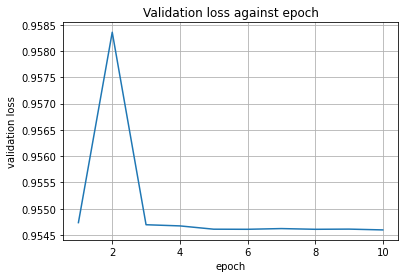

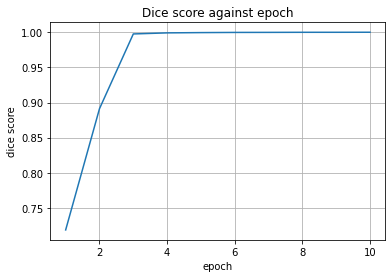

In [8]:
import matplotlib.pyplot as plt

m_loss=[]
for loss in val_losses:
  m_loss.append(float(loss.cpu()))

m_dice=[]
for dice in dice_scores:
  m_dice.append(float(dice.cpu()))

t = [i for i in range(1,NUM_EPOCHS+1)]


fig, ax = plt.subplots()
ax.plot(t, m_loss)

ax.set(xlabel='epoch', ylabel='validation loss',
       title='Validation loss against epoch')
ax.grid()

plt.show()


fig, ax = plt.subplots()
ax.plot(t, m_dice)

ax.set(xlabel='epoch', ylabel='dice score',
       title='Dice score against epoch')
ax.grid()

plt.show()

In [11]:
# def test(loader, model, loss_fn, device="cuda"):
#     num_correct = 0
#     num_pixels = 0
#     dice_score = 0
#     model.eval()

#     with torch.no_grad():
#         for x, y in loader:
#             # print("x: ", x.shape)
#             # print("y: ", y.shape)
#             x = x.unsqueeze(1).to(device)
#             # print("x: ", x.shape)
#             y = y.unsqueeze(1).to(device)
#             # print("mo la")
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#             loss = loss_fn.forward(preds,y)
#             num_correct += (preds == y).sum()
#             num_pixels += torch.numel(preds)
#             dice_score += (2 * (preds * y).sum()) / (
#                 (preds + y).sum() + 1e-8
#             )

#     print(
#         f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
#     )
#     print(f"Dice score: {dice_score/len(loader)}")
#     model.train()
#     return loss, dice_score/len(loader)

In [12]:
# def save_predictions_as_imgs(
#     loader, model, device="cuda"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         # torchvision.utils.save_image(
#         #     preds, f"{folder}/pred_{idx}.png"
#         # )
#         # torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")
#     # print(type(preds))
#     # print(preds.shape)
#     model.train()
#     return preds

In [11]:
from utils import (load_scan, load_seg, findOrgan)

test_img_paths = []
test_seg_paths = []
test_dir = '/content/drive/MyDrive/MiCM2021-PKD/beta/MR2D/Test'
for dcm in os.listdir(test_dir + '/X'):
    if dcm != ".DS_Store":
        test_img_paths.append(test_dir + '/X/' + dcm)
test_img_paths.sort()

for seg in os.listdir(test_dir + '/Y'):
    if seg != ".DS_Store":
        test_seg_paths.append(test_dir + '/Y/' + seg)
test_seg_paths.sort()

## apply find organ on everything. then remove the all 0s
mylist = []
for idx in range(len(test_img_paths)):
    img = load_scan(test_img_paths[idx])
    seg = load_seg(test_seg_paths[idx])
    bin_img, bin_seg = findOrgan(img,seg,ORGAN)
    if np.amax(bin_seg) != 0:
        mylist.append(idx)

cleaned_test_img_paths = []
cleaned_test_seg_paths = []
for idx in mylist:
    cleaned_test_img_paths.append(test_img_paths[idx])
    cleaned_test_seg_paths.append(test_seg_paths[idx])

Total_Test = SliceDataset(cleaned_test_img_paths, cleaned_test_seg_paths, organ=ORGAN, transform=None, test=True)


# mylist = remove_bg_only_test(test_seg_paths)
# cleaned_test_img_paths, cleaned_test_seg_paths = clean_test_ds(test_img_paths, test_seg_paths, mylist)

test_idx = random.sample(range(0, len(cleaned_test_img_paths)), 10)

sampled_test_img_paths = []
sampled_test_seg_paths = []

for idx in test_idx:
    sampled_test_img_paths.append(cleaned_test_img_paths[idx])
    sampled_test_seg_paths.append(cleaned_test_seg_paths[idx])

# Test = SliceDataset(sampled_test_img_paths, sampled_test_seg_paths, transform=None)

## TOTAL
test_loader = DataLoader(Total_Test,1)

loop = tqdm(test_loader, position=0, leave=True)

preds = []
ground = []

for batch_idx, (data, targets) in enumerate(loop):
    data = data.unsqueeze(1).to(device=DEVICE)


    pred = torch.sigmoid(UNet(data))
    pred = (pred > 0.5).float()

    preds.append(pred.detach().cpu().numpy()[0][0])

    targets = targets.float().unsqueeze(1).to(device=DEVICE)
    ground.append(targets.detach().cpu().numpy()[0][0])


## SAMPLE
Sample_Test = SliceDataset(sampled_test_img_paths, sampled_test_seg_paths, organ=ORGAN, transform=None, test=True)
sample_test_loader = DataLoader(Sample_Test)

sample_loop = tqdm(sample_test_loader, position=0, leave=True)

sample_preds = []
sample_ground = []

for batch_idx, (data, targets) in enumerate(sample_loop):
    data = data.unsqueeze(1).to(device=DEVICE)


    pred = torch.sigmoid(UNet(data))
    pred = (pred > 0.5).float()

    sample_preds.append(pred.detach().cpu().numpy()[0][0])

    targets = targets.float().unsqueeze(1).to(device=DEVICE)
    sample_ground.append(targets.detach().cpu().numpy()[0][0])


    


100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


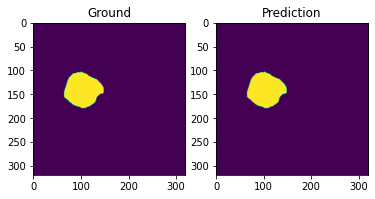

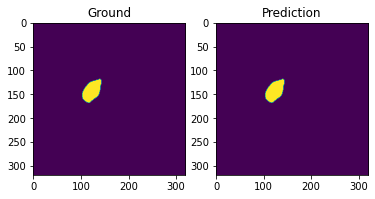

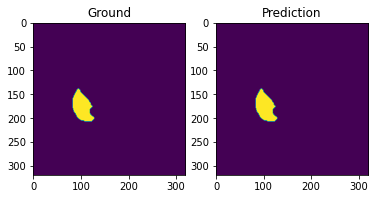

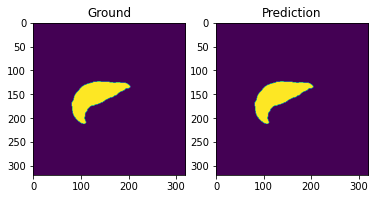

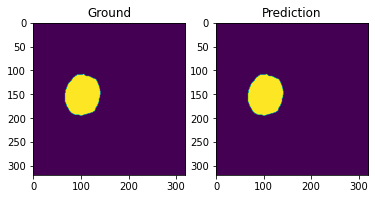

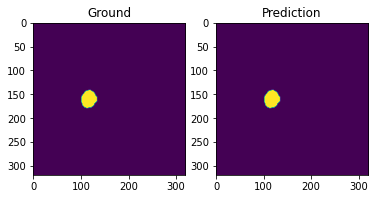

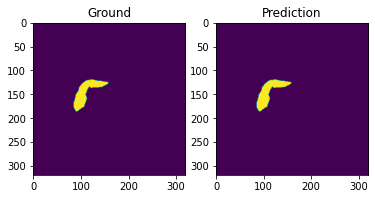

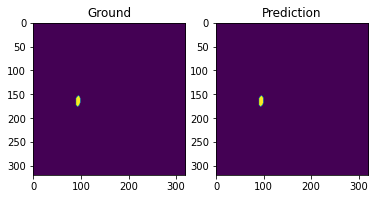

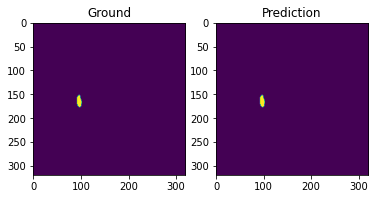

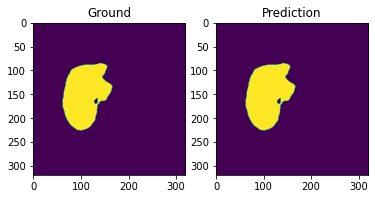

In [14]:
for idx in range(len(sample_preds)):

  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(sample_ground[idx])
  axarr[0].title.set_text('Ground')
  axarr[1].imshow(sample_preds[idx])
  axarr[1].title.set_text('Prediction')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


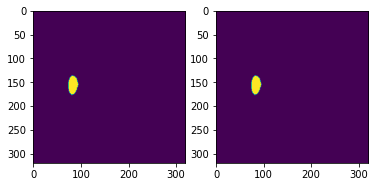

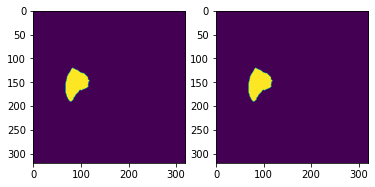

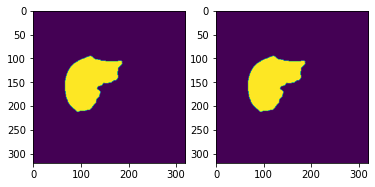

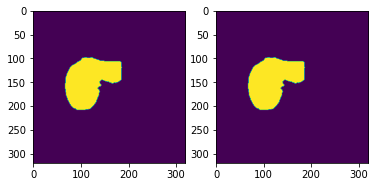

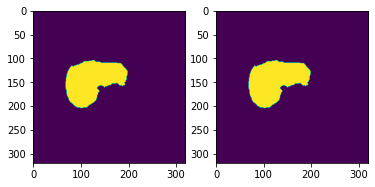

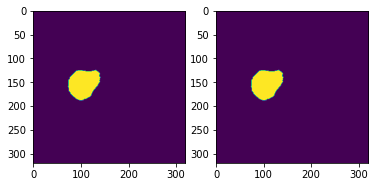

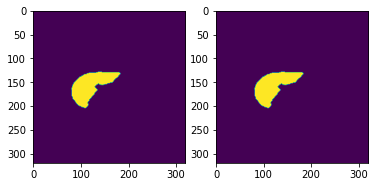

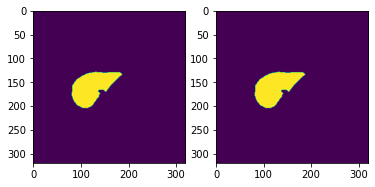

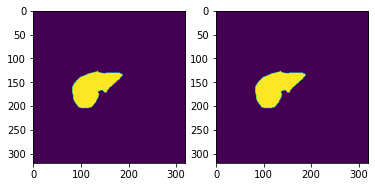

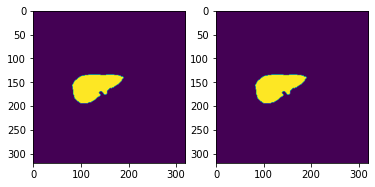

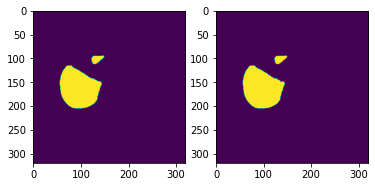

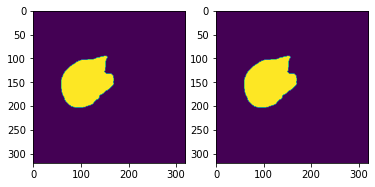

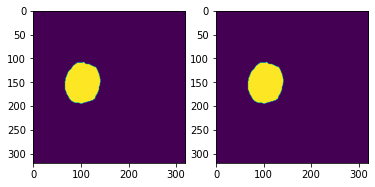

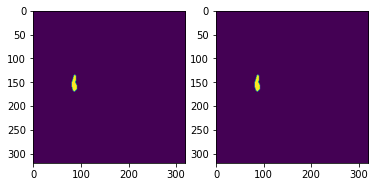

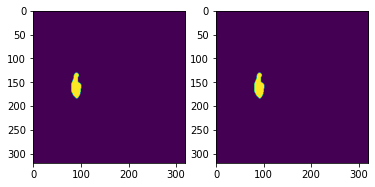

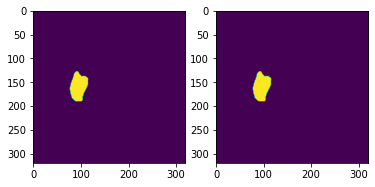

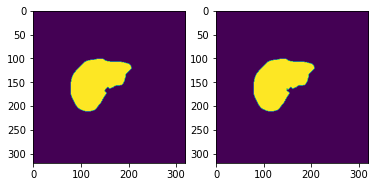

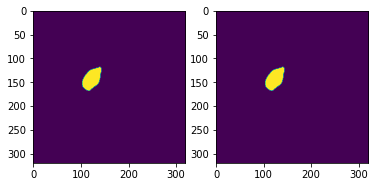

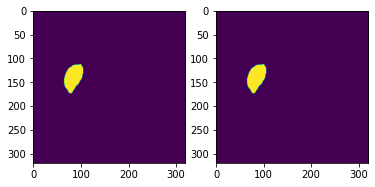

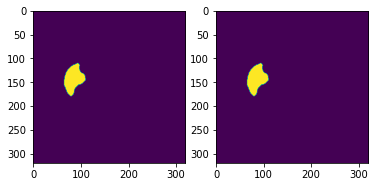

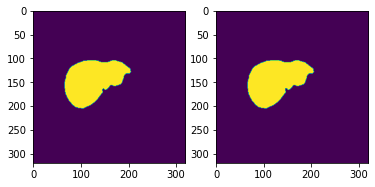

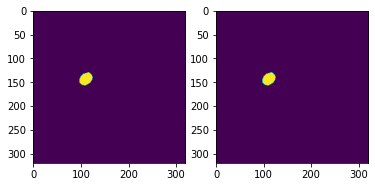

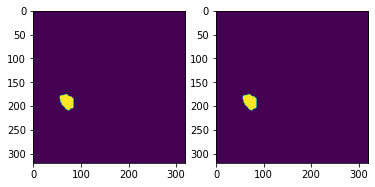

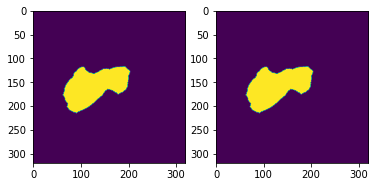

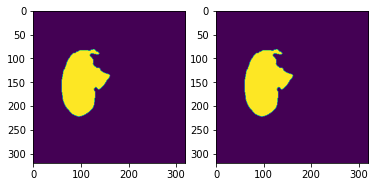

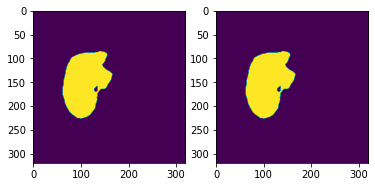

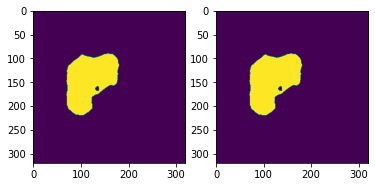

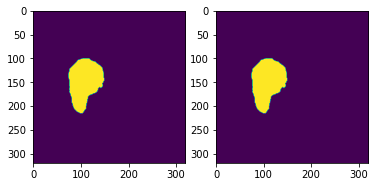

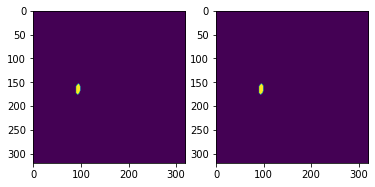

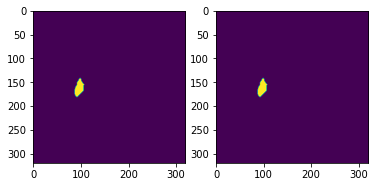

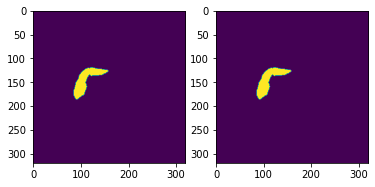

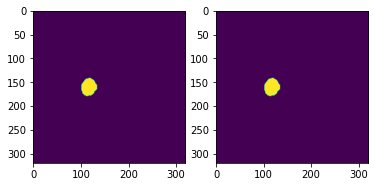

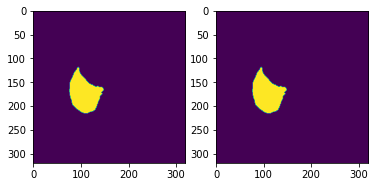

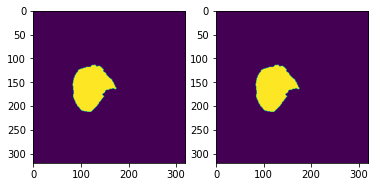

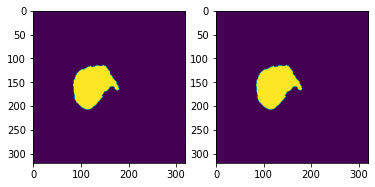

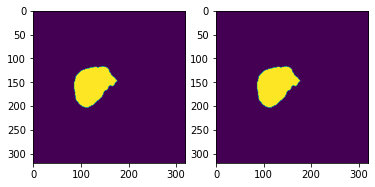

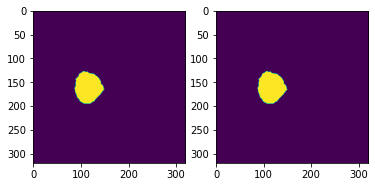

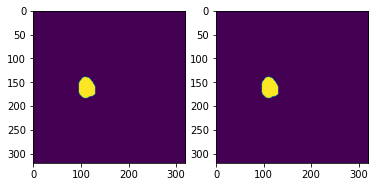

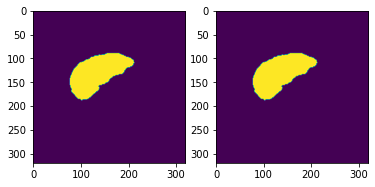

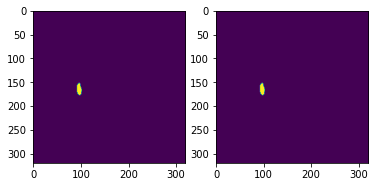

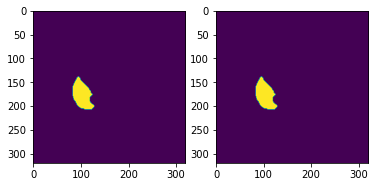

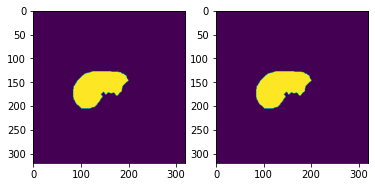

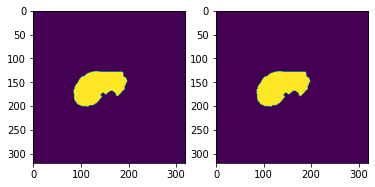

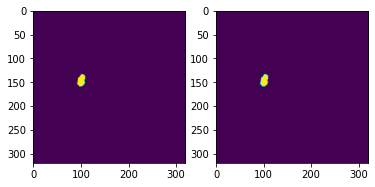

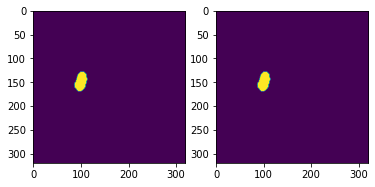

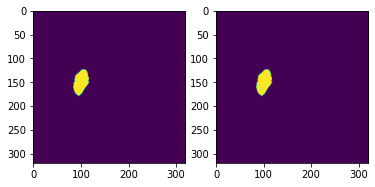

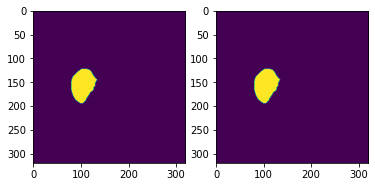

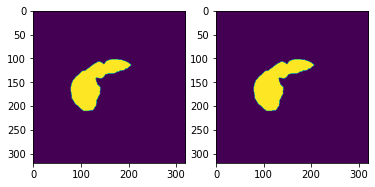

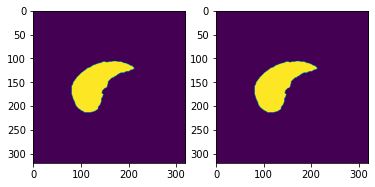

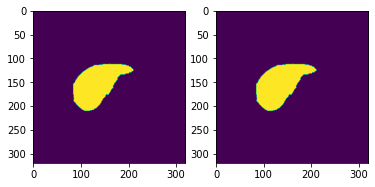

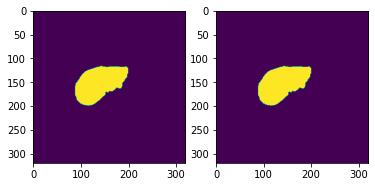

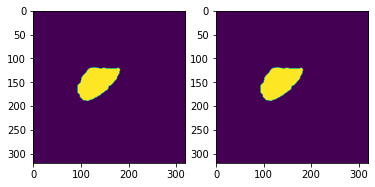

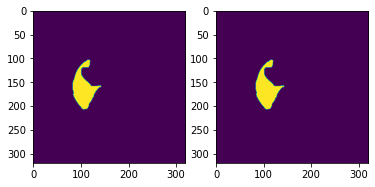

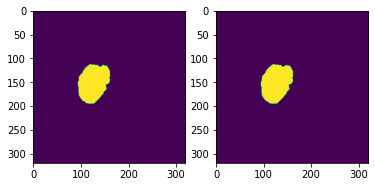

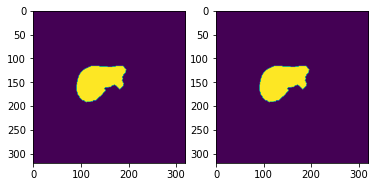

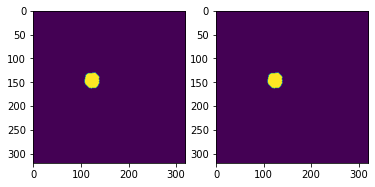

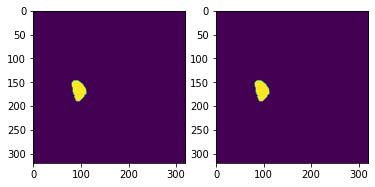

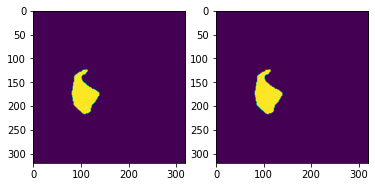

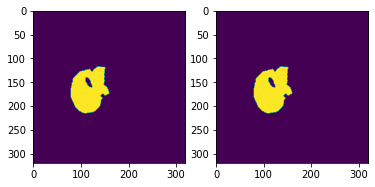

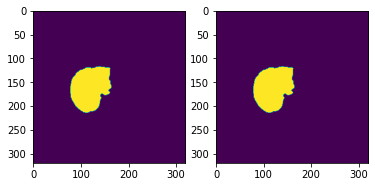

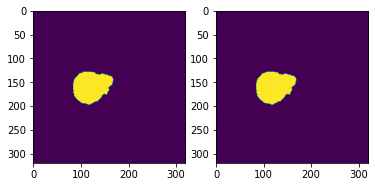

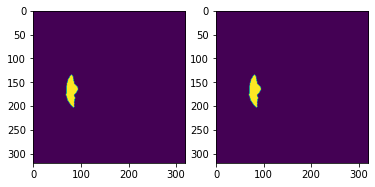

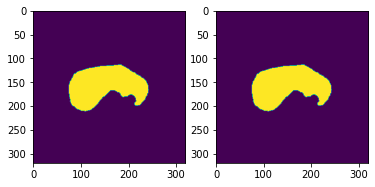

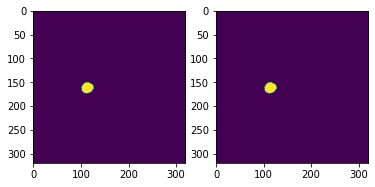

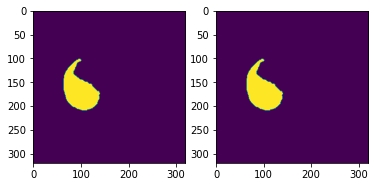

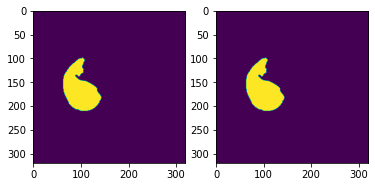

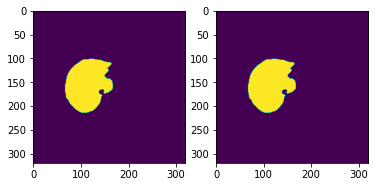

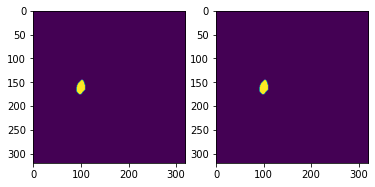

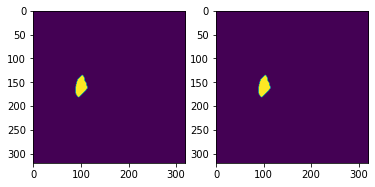

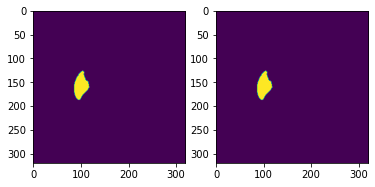

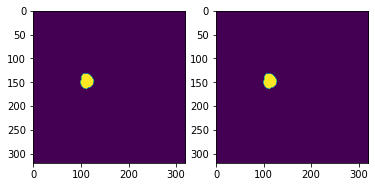

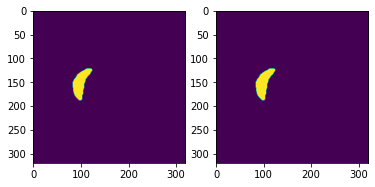

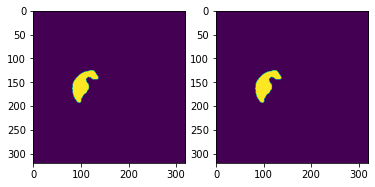

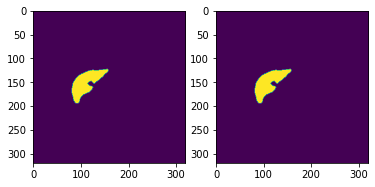

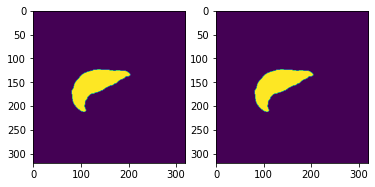

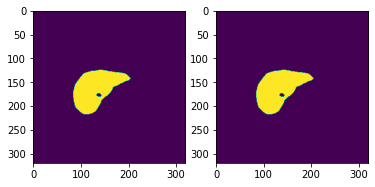

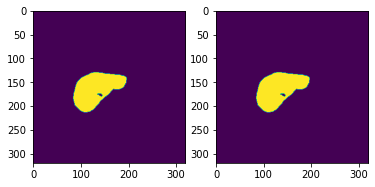

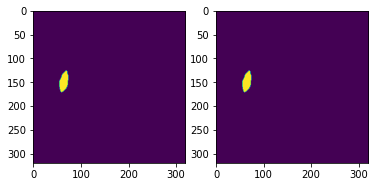

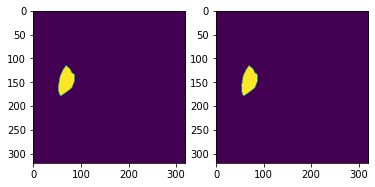

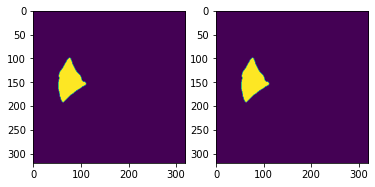

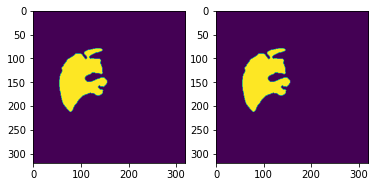

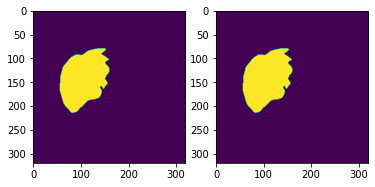

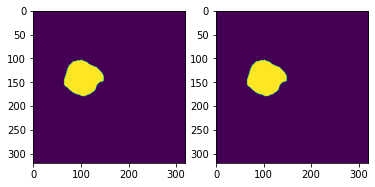

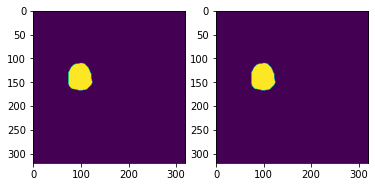

In [10]:
for idx in range(len(preds)):

  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(ground[idx])
  axarr[1].imshow(preds[idx])
# for idx in range(len(preds)):
#   axarr[idx, idx%2].imshow(preds[idx])
#   axarr[idx, idx%2].imshow(ground[idx])